In [ ]:
# "I certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I did not receive any external help, coaching or contributions during the production of this work."

In [ ]:
!pip install gym

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [3]:
from google.colab import widgets
import time

#Part II

##GridEnvironment

In [4]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):
        self.observation_space = spaces.Discrete(16) #Intializing a 4x4 grid with 16 states: {s1, s2, s3,....s16}
        self.action_space = spaces.Discrete(4) #Intializing 4 actions:  {0: down, 1: up, 2: right, 3: left}
        self.done = False
        #rewards = {-2, -1, 0, 3, 4, 100} defined below
        
    def reset(self):
  
        self.agent_pos = [0, 0] #start position
        self.goal_pos = [3, 3] #target position (+100)
        self.danger1_pos = [1,1] #first danger position (-1)
        self.danger2_pos = [2,2] #second danger position (-2)
        self.gold1_pos = [2,0] #First positive reward position (+3)
        self.gold2_pos = [3,0] #Second positive reward position (+4)
        self.done = False
        self.state = np.zeros((4,4))
        observation = self.state.flatten()
        return observation
    
    def step(self, action, deterministic = False, stochastic = False):

        #determinstic environment
        if deterministic == True:
          epsilon1, epsilon2 = 1, 1 #With probability 1 Agent chooses given action

        #stochastic environment
        if stochastic == True:
          epsilon1, epsilon2 = 0.7, 0.8 #Transistion probabilites of 0.7 and 0.8 
          #Σ(p(s', r/s, down) = 0.7 + 0.3 = 1
          #Σ(p(s', r/s, right) = 0.8 + 0.2 = 1 

        #Actions
        if action == 0: #down
            rand_num1 = np.random.random()
            if epsilon1 >= rand_num1:  
              self.agent_pos[0] += 1   
            else: #For all states in stochastic environment when Down action is choosen: Agent chooses down state with a transition probability of 0.7 and up state with 0.3 transition probaility
              self.agent_pos[0] -= 1
              # print("Up state is choosen with 0.3 probability instead of Down")

        if action == 1: #up
            self.agent_pos[0] -= 1

        if action == 2: #right
            rand_num2 = np.random.random()
            if epsilon2 >= rand_num2:  
              self.agent_pos[1] += 1        
            else:#For all states in stochastic environment when Right action is choosen: Agent chooses right state with a transition probability of 0.8 and left state with 0.2 transition probaility
              self.agent_pos[1] -= 1
              # print("Left state is choosen with 0.2 probability instead of Right")

        if action == 3: #left
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3) #ensuring agent doesn't go out of the grid #One of the ways to ensure safety in the environment
        self.state = np.zeros((4,4))

        observation = self.state.flatten()
        
        reward = 0 #Intializing reward to zero
        if (self.agent_pos == self.goal_pos).all():
            reward = 100 #A reward of 5 if it reaches target position
            self.done = True

        #Rewards structure
        elif (self.agent_pos == self.danger1_pos).all():
            reward = -1 #A negative reward -1 if it enters 1st danger position

        elif (self.agent_pos == self.danger2_pos).all():
            reward = -2 #A negative reward of -2 if it enters 2nd danger position

        elif (self.agent_pos == self.gold1_pos).all():
            reward = 3 #A reward of +3 at [2,0]

        elif (self.agent_pos == self.gold2_pos).all():
            reward = 4 #A reward of +3 at [3,0]

        return reward, self.agent_pos, self.done
        
    def render(self):
        plt.imshow(self.state)

In [7]:
class RandomAgent: #Definig the Random agent class
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, observation): #Just for reference I have developed action space in algorithm #Random agent chooses random action every time we call step method
        return np.random.choice(self.action_space.n)

## Q-Learning Algorithm

In [11]:
#Q-learning

def q_learning(deterministic = False, stochastic = False, evaluation_results = False, qlearning_rewards = False):
  env = GridEnvironment()
  agent = RandomAgent(env)#creating a random agent to explore the given environments 
  obs = env.reset()#resets the environment to its initial configuration

  #Displays grid in its intial configuration
  print("Grid Environment\n")
  output_grid2 = widgets.Grid(4, 4, header_row=True, header_column=True,  style='background-color: black; font-size: 25px; color: white')
  print("\n")
  with output_grid2.output_to(0, 0):
      print("Start")
  with output_grid2.output_to(3, 3):
      print("Target")
  with output_grid2.output_to(1, 1):
      print("-1")
  with output_grid2.output_to(2, 2):
      print("-2")
  with output_grid2.output_to(2, 0):
      print("+3")
  with output_grid2.output_to(3, 0):
      print("+4")

  
  #Intialize parameters
  learning_rate = 0.15 #alpha
  discount_factor = 0.95 #how much weightage to put on future rewards
  det_epsilon = 0.99 # For all states in deterministic environment p(s', r/s, a) = {0, 1}: Either action taken or No action taken


  #Intial state
  current_state = 0 #s1
  action_val = [0,1,2,3]

  #Q table representing 16 rows: one for each state (i.e., 0,1,2,...15) -> (i.e., s1, s2, s3,....s16) and 4 columns: one for each action (i.e., 0,1,2,3) -> (down,up,right,left)
  # (0-15, 0-3) remember the dimension is one less
  q_table = np.zeros((16,4))

  #mapping next_state co-ordinates to q_table co-ordinates
  states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

  #Empty lists to store values
  optimal = []
  reward_values = []
  total_timesteps = []
  epsilon_values = []
  eva_rewards = []

  done = False #signifies if agent reached terminal or not 
  total_episodes = 1500
  eva_episodes = 10 #Used for evaluation
  avg_timesteps = 0
  epsilon = 1 #multiply by 0.995 for each episode(#after 20 iterations# or terminal state reached)
  decay_factor = (0.01/1)**(1/total_episodes)

  #For evaluation results
  if evaluation_results: 
     total_episodes += eva_episodes 
     print("Evaluation Results")

  for episode in range(1, total_episodes+1):
    
    obs = env.reset()
    current_state = 0
    total_rewards = 0
    timestep = 0

    while timestep < 20: #(i.e., considering untill the terminal is reached or 20 timesteps completed)
    
      # deterministic: {0,1} probability for deterministic #stochasticity in choosing an action for stochastic
      rand_num = np.random.random()
      if det_epsilon > rand_num: #Choosing an action in deterministic environment
          
          #e - greedy algorithm
          rand_num = np.random.random()
          if epsilon > rand_num:
            action = np.random.choice(action_val)
          else:
            action = np.argmax(q_table[current_state]) #action in current state s with max_q value

          #Taking the action
          reward, next_state_pos, done = env.step(action, deterministic, stochastic)

          next_state = states[tuple(next_state_pos)]

          #Choosing action with max Q value
          max_q_action = np.argmax(q_table[next_state])

          #Update function
          q_table[current_state][action] = q_table[current_state][action] + learning_rate*(reward + discount_factor*q_table[next_state][max_q_action] - q_table[current_state][action])

          if episode == total_episodes:
            optimal.append(current_state+1)

          total_rewards += reward #Captured all the rewards in each episode
          timestep += 1 #Number of timesteps in each episode

          current_state = next_state #next_state is assigned to current_state
          
          if done == True: #If terminal or target state reached then stop the episode
            done = False
            break        
          
    
    #Results after each episode
    avg_timesteps += timestep #Capturing all timesteps for all 100 episodes
    total_timesteps.append(avg_timesteps)

    reward_values.append(total_rewards) #Append rewards in every episode
    epsilon_values.append(epsilon) #Append epsilon values in every episode
    

    if epsilon > 0.01: #keeping epsilon in [0.01 - 1] range as if it falls below 0.01 it will exploit more: choosing best actions. We want our agent to explore a bit: choosing random actions
        epsilon = epsilon*decay_factor
    else:
        epsilon = 0.01


    if (episode % 100) == 0 and evaluation_results == False and qlearning_rewards == False: #printing results for every 100 episodes
      print("Episode: {}, Rewards: {}, Average timesteps taken: {}, epsilon: {}".format(episode, total_rewards, avg_timesteps//100, epsilon))
      avg_timesteps = 0


    #evaluation results
    if evaluation_results:
      if episode > total_episodes - eva_episodes:
         eva_rewards.append(reward)


    #printing the optimal path in last episode
    if episode == total_episodes:
          print("Optimal Path: ")
          for i in optimal:
            print(i,"->", end = " ")
          print(next_state+1)

    
  #rewards  
  if qlearning_rewards:
    return reward_values


  #Final Q - Table
  print("Q Table: \n", q_table)

  #Plotting the results
  #x, y co-ordinates
  x = [episode for episode in range(total_episodes)]
  yr = reward_values
  ye = epsilon_values
  yr_eva = eva_rewards
  x_eva = [episode for episode in range(eva_episodes)]
 

  if evaluation_results:
      #episodes vs rewards
      plt.plot(x_eva,yr_eva)
      plt.title("Rewards per episode")
      plt.xlabel('Episodes')
      plt.ylabel('Rewards')

  else:
      
      #Plots showing episodes vs epsilon, episodes vs rewards
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
      #episodes vs epsilon
      ax1.plot(x, ye)
      ax1.set_title("Epsilon decay")
      

      #episodes vs rewards
      ax2.plot(x,yr)
      ax2.set_title("Rewards per episode")
      

  



Q-Learning Deterministic environment

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Episode: 100, Rewards: -8, Average timesteps taken: 17, epsilon: 0.7356422544596452
Episode: 200, Rewards: 105, Average timesteps taken: 13, epsilon: 0.5411695265464691
Episode: 300, Rewards: 99, Average timesteps taken: 10, epsilon: 0.39810717055350314
Episode: 400, Rewards: 114, Average timesteps taken: 9, epsilon: 0.29286445646252957
Episode: 500, Rewards: 105, Average timesteps taken: 8, epsilon: 0.21544346900319378
Episode: 600, Rewards: 107, Average timesteps taken: 7, epsilon: 0.15848931924611603
Episode: 700, Rewards: 107, Average timesteps taken: 6, epsilon: 0.11659144011798714
Episode: 800, Rewards: 107, Average timesteps taken: 6, epsilon: 0.08576958985909275
Episode: 900, Rewards: 107, Average timesteps taken: 6, epsilon: 0.06309573444802206
Episode: 1000, Rewards: 107, Average timesteps taken: 6, epsilon: 0.04641588833613003
Episode: 1100, Rewards: 107, Average timesteps taken: 6, epsilon: 0.03414548873833783
Episode: 1200, Rewards: 107, Average timesteps taken: 6, epsilon

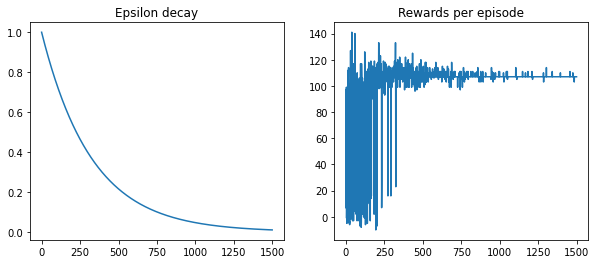

In [12]:
q_learning(deterministic = True)

Q-Learning Stochastic environment

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Episode: 100, Rewards: 1, Average timesteps taken: 19, epsilon: 0.7356422544596452
Episode: 200, Rewards: 13, Average timesteps taken: 19, epsilon: 0.5411695265464691
Episode: 300, Rewards: 54, Average timesteps taken: 20, epsilon: 0.39810717055350314
Episode: 400, Rewards: 40, Average timesteps taken: 20, epsilon: 0.29286445646252957
Episode: 500, Rewards: 58, Average timesteps taken: 20, epsilon: 0.21544346900319378
Episode: 600, Rewards: 32, Average timesteps taken: 20, epsilon: 0.15848931924611603
Episode: 700, Rewards: 70, Average timesteps taken: 20, epsilon: 0.11659144011798714
Episode: 800, Rewards: 61, Average timesteps taken: 20, epsilon: 0.08576958985909275
Episode: 900, Rewards: 58, Average timesteps taken: 20, epsilon: 0.06309573444802206
Episode: 1000, Rewards: 75, Average timesteps taken: 20, epsilon: 0.04641588833613003
Episode: 1100, Rewards: 71, Average timesteps taken: 20, epsilon: 0.03414548873833783
Episode: 1200, Rewards: 67, Average timesteps taken: 20, epsilon: 

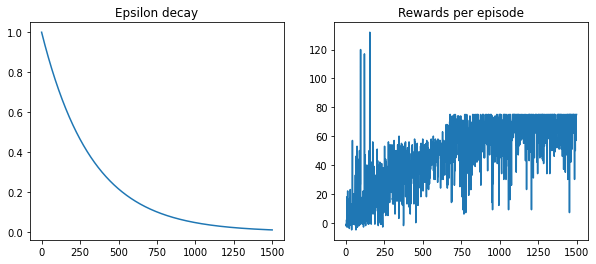

In [13]:
q_learning(stochastic= True)

##SARSA Algorithm

In [16]:
#SARSA
def sarsa(deterministic = False, stochastic = False, evaluation_results = False, sarsa_rewards = False):
  env = GridEnvironment()
  agent = RandomAgent(env)#creating a random agent to explore the given environments 
  obs = env.reset()#resets the environment to its initial configuration

  #Displays grid in its intial configuration
  print("Grid Environment\n")
  output_grid2 = widgets.Grid(4, 4, header_row=True, header_column=True,  style='background-color: black; font-size: 25px; color: white')
  print("\n")
  with output_grid2.output_to(0, 0):
      print("Start")
  with output_grid2.output_to(3, 3):
      print("Target")
  with output_grid2.output_to(1, 1):
      print("-1")
  with output_grid2.output_to(2, 2):
      print("-2")
  with output_grid2.output_to(2, 0):
      print("+3")
  with output_grid2.output_to(3, 0):
      print("+4")


  #Intialize parameters
  learning_rate = 0.15 #alpha
  discount_factor = 0.95 #how much weightage to put on future rewards
  det_epsilon = 0.99 # For all states in deterministic environment p(s', r/s, a) = {0, 1}: Either action taken or No action taken


  #Intial state
  current_state = 0 #s1
  action_val = [0,1,2,3]

  #Q table representing 16 rows: one for each state (i.e., 0,1,2,...15) -> (i.e., s1, s2, s3,....s16) and 4 columns: one for each action (i.e., 0,1,2,3) -> (down,up,right,left)
  # (0-15, 0-3) remember the dimension is one less
  q_table = np.zeros((16,4))

  #mapping next_state co-ordinates to q_table co-ordinates
  states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

  #Empty lists to store values
  optimal = []
  reward_values = []
  total_timesteps = []
  epsilon_values = []
  eva_rewards = []


  done = False #signifies if agent reached terminal or not 
  total_episodes = 1500
  eva_episodes = 10
  avg_timesteps = 0
  epsilon = 1 #multiply by 0.995 for each episode(#after 30 iterations# or terminal state reached)
  decay_factor = (0.01/1)**(1/total_episodes)

  #For evaluation results
  if evaluation_results: 
     total_episodes += eva_episodes 
     print("Evaluation Results")

  for episode in range(1, total_episodes+1):
    
    obs = env.reset() #resets the environment
    current_state = 0 
    total_rewards = 0
    timestep = 0


    #e - greedy algorithm to choose s and a
    rand_num = np.random.random()
    if epsilon > rand_num:
      action = np.random.choice(action_val)
    else:
      action = np.argmax(q_table[current_state]) #action in current state s with max_q value

    while timestep < 20: #(i.e., considering untill the terminal is reached or 20 timesteps are completed)
    
      # deterministic: {0,1} probability for deterministic #stochasticity in choosing an action for stochastic
      rand_num = np.random.random()
      if det_epsilon > rand_num: #Choosing an action in deterministic environment
          
          reward, next_state_pos, done = env.step(action, deterministic, stochastic)
          next_state = states[tuple(next_state_pos)]

          #e - greedy algorithm to choose next_action for next_state
          rand_num = np.random.random()
          if epsilon > rand_num:
            next_action = np.random.choice(action_val)
          else:
            next_action = np.argmax(q_table[next_state]) #action in next state s' with max_q value
          
          #q-value update function for SARSA
          q_table[current_state][action] = q_table[current_state][action] + learning_rate*(reward + discount_factor*q_table[next_state][next_action] - q_table[current_state][action])

          if episode == total_episodes:
            optimal.append(current_state+1)

          total_rewards += reward #Captured all the rewards in each episode
          timestep += 1 #Number of timesteps in each episode

          current_state = next_state #next_state is assigned to current_state
          action = next_action
          
          if done == True: #If terminal or target state reached then stop the episode
            done = False
            break        
          
    
    #Results after each episode
    avg_timesteps += timestep #Capturing all timesteps for all 100 episodes
    total_timesteps.append(avg_timesteps)

    reward_values.append(total_rewards) #Append rewards in every episode
    epsilon_values.append(epsilon) #Append epsilon values in every episode
    

    if epsilon > 0.01: #keeping epsilon in [0.01 - 1] range as if it falls below 0.01 it will exploit more: choosing best actions. We want our agent to explore a bit: choosing random actions
        epsilon = epsilon*decay_factor
    else:
        epsilon = 0.01


    if (episode % 100) == 0 and evaluation_results == False and sarsa_rewards == False: #printing results for every 100 episodes
      print("Episode: {}, Rewards: {}, Average timesteps taken: {}, epsilon: {}".format(episode, total_rewards, avg_timesteps//100, epsilon))
      avg_timesteps = 0

    #evaluation results
    if evaluation_results:
      if episode > total_episodes - eva_episodes:
         eva_rewards.append(reward)

    #printing the optimal path in last episode
    if episode == total_episodes:
          print("Optimal Path: ")
          for i in optimal:
            print(i,"->", end = " ")
          print(next_state+1)

  #rewards  
  if sarsa_rewards:
      return reward_values

  #Final Q - Table
  print("Q Table: \n", q_table)

  #Plotting the results
  #x, y co-ordinates
  x = [episode for episode in range(total_episodes)]
  yr = reward_values
  ye = epsilon_values

  yr_eva = eva_rewards
  x_eva = [episode for episode in range(eva_episodes)]
 

  if evaluation_results:
      #episodes vs rewards
      plt.plot(x_eva,yr_eva)
      plt.title("Rewards per episode")
      plt.xlabel('Episodes')
      plt.ylabel('Rewards')

  else:
      #episodes vs epsilon
      #Plots showing episodes vs epsilon, episodes vs rewards
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
      ax1.plot(x, ye)
      ax1.set_title("Epsilon decay")

      #episodes vs rewards
      ax2.plot(x,yr)
      ax2.set_title("Rewards per episode")



SARSA Deterministic environment

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Episode: 100, Rewards: -3, Average timesteps taken: 18, epsilon: 0.7356422544596452
Episode: 200, Rewards: 97, Average timesteps taken: 13, epsilon: 0.5411695265464691
Episode: 300, Rewards: 95, Average timesteps taken: 11, epsilon: 0.39810717055350314
Episode: 400, Rewards: 107, Average timesteps taken: 9, epsilon: 0.29286445646252957
Episode: 500, Rewards: 107, Average timesteps taken: 8, epsilon: 0.21544346900319378
Episode: 600, Rewards: 103, Average timesteps taken: 7, epsilon: 0.15848931924611603
Episode: 700, Rewards: 106, Average timesteps taken: 6, epsilon: 0.11659144011798714
Episode: 800, Rewards: 107, Average timesteps taken: 6, epsilon: 0.08576958985909275
Episode: 900, Rewards: 107, Average timesteps taken: 6, epsilon: 0.06309573444802206
Episode: 1000, Rewards: 107, Average timesteps taken: 6, epsilon: 0.04641588833613003
Episode: 1100, Rewards: 107, Average timesteps taken: 6, epsilon: 0.03414548873833783
Episode: 1200, Rewards: 107, Average timesteps taken: 6, epsilon:

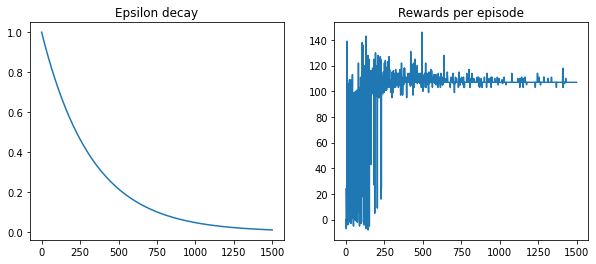

In [17]:
sarsa(deterministic = True)

SARSA Stochastic environment

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Episode: 100, Rewards: 16, Average timesteps taken: 19, epsilon: 0.7356422544596452
Episode: 200, Rewards: 20, Average timesteps taken: 19, epsilon: 0.5411695265464691
Episode: 300, Rewards: 9, Average timesteps taken: 18, epsilon: 0.39810717055350314
Episode: 400, Rewards: 48, Average timesteps taken: 16, epsilon: 0.29286445646252957
Episode: 500, Rewards: 51, Average timesteps taken: 19, epsilon: 0.21544346900319378
Episode: 600, Rewards: 60, Average timesteps taken: 20, epsilon: 0.15848931924611603
Episode: 700, Rewards: 63, Average timesteps taken: 19, epsilon: 0.11659144011798714
Episode: 800, Rewards: 37, Average timesteps taken: 20, epsilon: 0.08576958985909275
Episode: 900, Rewards: 59, Average timesteps taken: 20, epsilon: 0.06309573444802206
Episode: 1000, Rewards: 70, Average timesteps taken: 20, epsilon: 0.04641588833613003
Episode: 1100, Rewards: 75, Average timesteps taken: 20, epsilon: 0.03414548873833783
Episode: 1200, Rewards: 70, Average timesteps taken: 20, epsilon: 

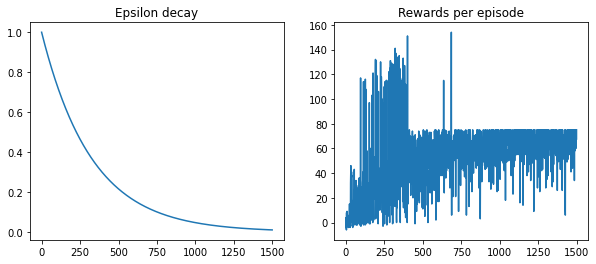

In [18]:
sarsa(stochastic = True)

##Evaluation Results

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Evaluation Results
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 16
Q Table: 
 [[ 83.83809375  79.64589243  75.66284679  79.64594412]
 [ 76.92822259  61.41210746  65.27750844  79.64603354]
 [ 79.84511118  41.71812196  19.25811412  34.09899186]
 [ 51.29748048   1.21195031  10.56239356   5.39326265]
 [ 88.250625    79.64529365  78.61788724  83.83807293]
 [ 81.6341517   61.88522423  83.83506823  79.10248005]
 [ 88.24969515  52.96123155  66.25563017  76.20030705]
 [ 89.37645141   7.2617063   38.41980329  61.35237884]
 [ 89.7375      83.83785211  85.73735927  88.24993784]
 [ 90.24999999  76.10367542  87.07537435  85.29739041]
 [ 94.99999987  79.73046177  93.4524722   84.10991257]
 [ 99.89145873  49.34170142  49.01263285  50.79364863]
 [ 89.73708751  88.25028955  90.25        89.73746592]
 [ 90.24997071  85.73716303  95.          89.73748597]
 [ 94.9999887   88.24973599 100.          90.24965367]
 [  0.           0.           0.           0.        ]]


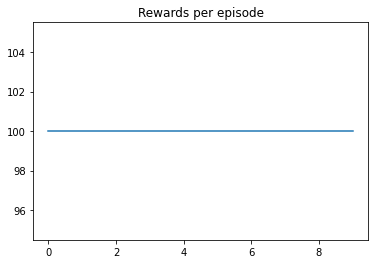

In [ ]:
q_learning(deterministic = True, evaluation_results = True)

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Evaluation Results
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 14 -> 15 -> 16
Q Table: 
 [[75.03748985 64.61167959 63.53591499 65.82906042]
 [66.37661499 65.76619634 66.06073416 65.87804877]
 [71.21389464 69.34472862 69.99860481 66.33963787]
 [73.05973234 72.38484162 71.98680089 69.68104443]
 [80.30574925 68.07539448 68.07074659 67.95427081]
 [70.56847158 65.56779712 71.04969637 70.06204595]
 [75.13391516 68.61397539 75.22118693 69.62354723]
 [79.57861049 72.83645307 75.4226713  74.7763677 ]
 [83.62014274 74.13056572 76.22383291 77.12647935]
 [78.7112925  68.71488483 79.29902695 77.98790897]
 [88.60073717 74.17472229 83.70267394 76.81385498]
 [92.30583468 80.52301087 83.49639431 80.74749646]
 [82.5514594  82.24527944 86.83444756 84.47357838]
 [83.89227389 77.87164385 92.25119047 85.65726777]
 [87.95230575 82.01900422 97.53062105 86.87566692]
 [ 0.          0.          0.          0.        ]]


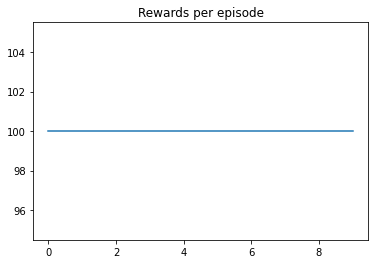

In [ ]:
q_learning(stochastic = True, evaluation_results = True)

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Evaluation Results
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 16
Q Table: 
 [[ 83.671913    74.23238071  56.36738018  74.16762852]
 [ 68.09276279  30.11918671  24.6590761   10.09357732]
 [ 50.43962002  19.10293763   0.51485127   6.64727157]
 [  0.90036127   0.4933422    0.31106529   4.67015836]
 [ 88.20046484  65.15625947  72.4677864   79.02130636]
 [ 83.21186818  28.22797164  52.81977239  49.94523519]
 [ 78.69125423  11.83526948  38.99935511  12.58500663]
 [ 73.44293034   0.72569708  21.72665807  19.20595587]
 [ 89.7328565   77.34807959  82.48204496  86.02320423]
 [ 90.01288411  46.44429808  71.13173783  72.39392268]
 [ 71.99284786  47.63279641  91.00808333  42.55640508]
 [ 99.99999982  27.18759421  84.79950075  51.51093542]
 [ 85.41480919  81.91597894  90.24990314  85.89816658]
 [ 88.29434069  80.17700207  94.99999992  85.65561805]
 [ 94.52905251  80.0535138  100.          86.80315394]
 [  0.           0.           0.           0.        ]]


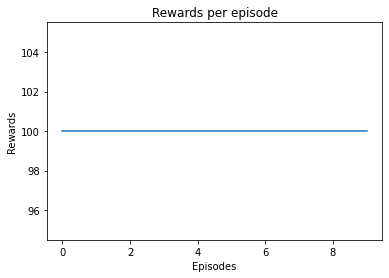

In [19]:
sarsa(deterministic = True, evaluation_results = True)

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Evaluation Results
Optimal Path: 
1 -> 1 -> 1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 14 -> 13 -> 14 -> 15 -> 14 -> 15 -> 16
Q Table: 
 [[ 6.63340592e+01  6.57857006e+01  5.89015494e+01  6.56912127e+01]
 [ 3.24754729e+01  2.08673705e+01  1.24518734e+01  6.38294743e+01]
 [ 3.58074590e+00  1.74016216e+00  1.53872125e-01  8.39382600e+00]
 [ 2.13598611e+01  2.57020507e+00  8.48108790e-01  2.80271322e-01]
 [ 7.43318808e+01  6.30844026e+01  6.06879670e+01  6.80160186e+01]
 [ 2.68991785e+01  1.90535201e+01  1.70860372e+01  6.74097215e+01]
 [ 5.47861129e+00 -2.01480445e-02  1.98614586e+01  7.64641061e+00]
 [ 4.43245997e+01  3.63972155e+00  4.37197943e+00  2.33706961e+00]
 [ 7.89400211e+01  6.82360713e+01  6.63998796e+01  7.37153561e+01]
 [ 5.78633299e+01  2.27481780e+01  3.71899934e+01  7.97806601e+01]
 [ 2.57567454e+01  1.20802310e+00  8.75478531e+01  1.76419436e+01]
 [ 9.79504955e+01  6.93482500e+00  2.93896081e+01  1.14283312e+01]
 [ 8.04240398e+01  7.63983011e+01  8.44863606e+01  8.07364334e+01]
 [

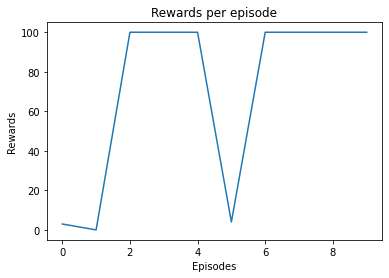

In [23]:
sarsa(stochastic = True, evaluation_results = True)

##Comparisons

Deterministic environments

In [27]:
yq_r = q_learning(deterministic = True, qlearning_rewards = True)
ys_r = sarsa(deterministic = True, sarsa_rewards = True)

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Optimal Path: 
1 -> 2 -> 3 -> 7 -> 8 -> 12 -> 16
Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 16


Text(0.5, 1.0, 'Deterministic Environment')

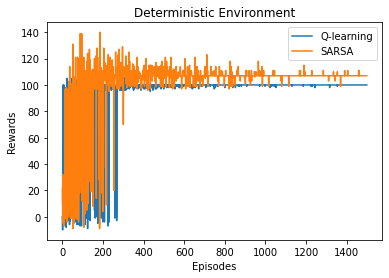

In [28]:
#Rewards for Q-learning and SARSA
yq = yq_r
ys = ys_r
episodes = len(yq_r)
x = [x for x in range(episodes)]
plt.plot(x, yq)
plt.plot(x, ys)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(["Q-learning", "SARSA"])
plt.title("Deterministic Environment")

Stochastic Environment

In [36]:
yq_r = q_learning(stochastic = True, qlearning_rewards = True)
ys_r = sarsa(stochastic = True, sarsa_rewards = True)

Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Optimal Path: 
1 -> 5 -> 1 -> 1 -> 5 -> 1 -> 1 -> 5 -> 1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 14 -> 15 -> 16
Grid Environment



,,,
,,,
,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Target


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

+4


<IPython.core.display.Javascript object>

Optimal Path: 
1 -> 1 -> 5 -> 9 -> 13 -> 14 -> 13 -> 14 -> 13 -> 13 -> 14 -> 13 -> 14 -> 15 -> 16


Text(0.5, 1.0, 'Stochastic Environment')

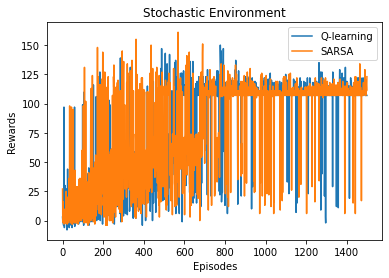

In [37]:
#Rewards for Q-learning and SARSA
yq = yq_r
ys = ys_r
episodes = len(yq_r)
x = [x for x in range(episodes)]
plt.plot(x, yq)
plt.plot(x, ys)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend(["Q-learning", "SARSA"])
plt.title("Stochastic Environment")